In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 
from time import time
import numpy as np
import pandas as pd
from statsmodels.tools.eval_measures import rmse
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
from sklearn import tree
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Activation, Flatten, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))



import sys  
sys.path.append('../')
from util import importNotebook
from util.util import *

## Load the datasets

In [13]:
(xTrain, _), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


## Declare the parameters

In [14]:
numEpochs = 50
sizeBatch = 32
dimEncode = 2
nameOptim = 'adam'

## Construct the encoder and decoder

In [15]:
layEncode = Dense(dimEncode, activation='relu')
layDecode = Dense(dimInput, activation='sigmoid')

inputs = Input(shape=(dimInput,))
latentEncode = layEncode(inputs)
encoder = Model(inputs, latentEncode)

inputLatent = Input(shape=(dimEncode,))
decode = layDecode(inputLatent)
decoder = Model(inputLatent, decode)

## Construct the autoencoder

In [16]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_4 (Model)              (None, 2)                 1570      
_________________________________________________________________
model_5 (Model)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [22]:
autoencoder.layers[1].get_weights()

[array([[ 0.06549824,  0.0177649 ],
        [ 0.07793086,  0.00755295],
        [-0.08328912,  0.07272368],
        ...,
        [-0.01513807,  0.04901154],
        [-0.01917326,  0.01428548],
        [-0.07407075, -0.02378273]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [6]:
autoencoder.compile(optimizer=nameOptim, loss='binary_crossentropy')
tic = time()
history = autoencoder.fit(xTrain, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
#                 shuffle=True,
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 92us/step - loss: 0.2738 - val_loss: 0.2429
Epoch 2/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.2411 - val_loss: 0.2379
Epoch 3/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.2373 - val_loss: 0.2352
Epoch 4/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.2347 - val_loss: 0.2330
Epoch 5/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.2325 - val_loss: 0.2310
Epoch 6/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.2305 - val_loss: 0.2292
Epoch 7/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.2289 - val_loss: 0.2279
Epoch 8/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.2278 - val_loss: 0.2270
Epoch 9/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.2271 - val_loss: 0.2264
Epoch

## Show the historical training progress 

traing consumed: 259.46555948257446 seconds


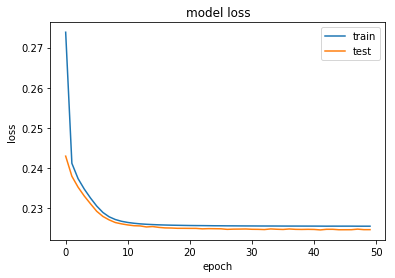

In [7]:
print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

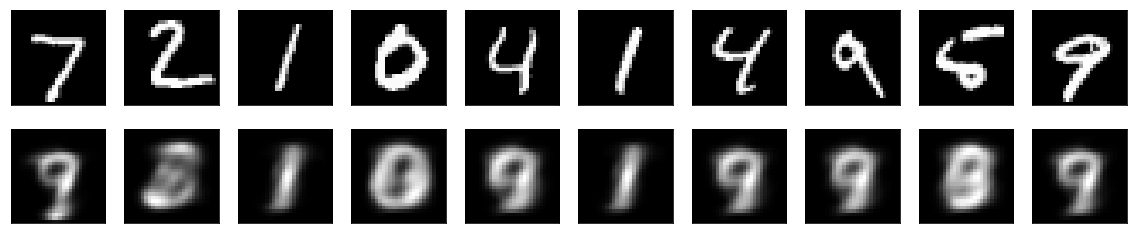

In [9]:
plotCompDecode(xTest, decodeTest)

## Plot the scatter of the encoding space

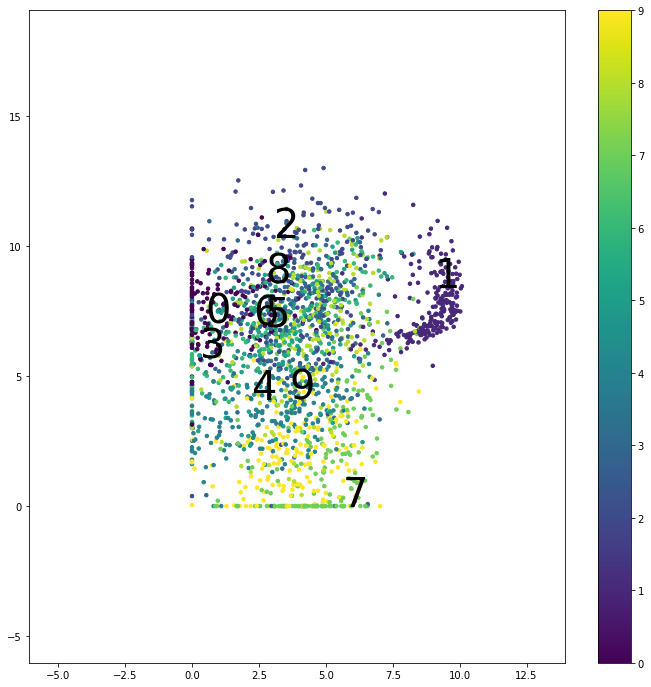

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

In [11]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, sizeDigit, xlim, ylim)

TypeError: object of type 'int' has no len()

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)